## Boston House Prices Dataset

Install tensorflow and tensorflow_probability if necessary:

In [1]:
#!pip install tensorflow
#!pip install tensorflow_probability

In [2]:
import utils_deconfounder
from utils_deconfounder import *


Check that it is the correct version of tf (v. 2.5 or at least 2.0 is needed in this project):

In [3]:
!pip show tensorflow
!pip show tensorflow_probability

Name: tensorflow
Version: 2.5.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/sophieroed/anaconda3/lib/python3.8/site-packages
Requires: google-pasta, wrapt, tensorboard, absl-py, protobuf, grpcio, numpy, wheel, opt-einsum, astunparse, h5py, keras-preprocessing, flatbuffers, typing-extensions, keras-nightly, termcolor, six, tensorflow-estimator, gast
Required-by: 
Name: tensorflow-probability
Version: 0.13.0
Summary: Probabilistic modeling and statistical inference in TensorFlow
Home-page: http://github.com/tensorflow/probability
Author: Google LLC
Author-email: no-reply@google.com
License: Apache 2.0
Location: /Users/sophieroed/anaconda3/lib/python3.8/site-packages
Requires: decorator, six, gast, numpy, dm-tree, cloudpickle
Required-by: 


Set a random seed:

In [4]:
randseed = 1789
print("random seed: ", randseed)
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

random seed:  1789


## Data

In [5]:
from sklearn.datasets import load_boston

In [6]:
data = load_boston()

It is possible to choose some of the features to work with if one has some knowlegde about, which are most relevant as causes; here we have chosen all:

In [7]:
num_fea = 13
df = pd.DataFrame(data["data"][:,:num_fea], columns=data["feature_names"][:num_fea])

In [8]:
df.shape

(506, 13)

In [9]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [10]:
dfy = data["target"]

We note that the outcome variable is real:

In [11]:
dfy.shape, dfy[:20] 

((506,),
 array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
        18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2]))

We will omit the highly correlated causes: "If two causes are highly correlated, a valid substitute confounder will largely inflate the variance of causal estimates downstream." See "a note on overlap" in the paper by Wang and Blei (2019).

We omit these much correlated causes by considering the scatter plots and removing based solely on these plots. The code for the plot is commented out as it takes a while to run it.

From the plot we see that all features are not too correlated and in all categorical variables, there are enought observations in each category. In conclusion, we do not omit any features.


In [12]:
#sns.pairplot(df, height=1.5)

The data ultimately have the following shape and we print the first rows of the dataset:

In [13]:
dfX = pd.DataFrame(df)

print(dfX.shape, dfy.shape)

(506, 13) (506,)


In [14]:
dfX.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


## Standerdize data and make train/ validation split

We standardize the data (not required in the deconfounder).

And then we hold out some data for the posterior predictive model check.

In [15]:
X = np.array((dfX - dfX.mean())/dfX.std()) # Standardize

If we whiten the data for the PICA LVM the model does not pass the model check using PPC:

In [16]:

#from scipy import linalg
#
#xc = dfX - np.mean(dfX, axis=0)
#
#print('xc.shape:', xc.shape, '\n')
#
## Calculate covariance matrix
#xcov = np.cov(xc, rowvar=True, bias=True)
#print('Covariance matrix: \n', xcov, '\n')
# 
## Calculate Eigenvalues and Eigenvectors
#w, v = linalg.eig(xcov)
## Note: Use w.real.round(4) to (1) remove 'j' notation to real, (2) round to '4' significant digits
#print("Eigenvalues:\n", w.real.round(4), '\n')
#print("Eigenvectors:\n", v, '\n')
# 
## Calculate inverse square root of Eigenvalues
## Optional: Add '.1e5' to avoid division errors if needed
## Create a diagonal matrix
#diagw = np.diag(1/(w**0.5)) # or np.diag(1/((w+.1e-5)**0.5))
#diagw = diagw.real.round(4) #convert to real and round off
#print("Diagonal matrix for inverse square root of Eigenvalues:\n", diagw, '\n')
# 
## Calculate Rotation (optional)
## Note: To see how data can be rotated
#xrot = np.dot(v, xc)
# 
## Whitening transform using PCA (Principal Component Analysis)
#X = np.dot(np.dot(diagw, v.T), xc)

Train / validation split:

In [17]:
num_datapoints, data_dim = X.shape

holdout_portion = 0.2

n_holdout = int(holdout_portion * num_datapoints * data_dim)

holdout_row = np.random.randint(num_datapoints, size=n_holdout)
holdout_col = np.random.randint(data_dim, size=n_holdout)

holdout_mask = (sparse.coo_matrix((np.ones(n_holdout),     #The data (ones) in any order
                            (holdout_row, holdout_col)),   # Indices of which rows and columns the data needs to be placed
                            shape = X.shape)).toarray()    # the shape of the entire matrix in which the data needs to be placed and other entries left empty

holdout_subjects = np.unique(holdout_row)
#print(holdout_mask)
holdout_mask = np.minimum(1, holdout_mask)                  # There were some repetitions, which also needs to be one

x_train = np.multiply(1-holdout_mask, X)
x_vad = np.multiply(holdout_mask, X)

## Fit latent variable model: PPCA

The model is defined and fitted using variational inference and the functions for this is found in the file "ultils_deconfounder.py".

In [18]:
model_ppca, surrogate_posterior_ppca, w_mean_ppca, w_stddv_ppca, z_mean_ppca, z_stddv_ppca, losses_ppca = fit_ppca(x_train = x_train,
                                                                                                                   latent_dim = 3,
                                                                                                                   mask = 1-holdout_mask,
                                                                                                                  stddv_datapoints = 0.5)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


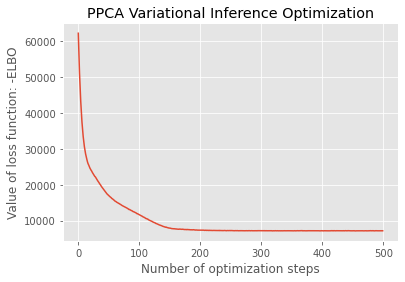

In [19]:
#print("Inferred parameters, W:")
#print(w_mean)
#print("Standard Deviation of inferred parameters, W:")
#print(w_stddv)

plt.plot(losses_ppca)
#plt.ylim(0,200000)
plt.xlabel("Number of optimization steps")
plt.ylabel("Value of loss function: -ELBO")
plt.title("PPCA Variational Inference Optimization")
plt.show()

#beingsaved = plt.figure()
#plt.plot(losses_ppca)
#plt.xlabel("Number of optimization steps")
#plt.ylabel("Value of loss function: -ELBO")
#plt.title("PPCA Variational Inference Optimization")
#beingsaved.savefig('ppca_vi_loss_plot.eps', format='eps', dpi=1200)


## Posterior Predictive Checks: PPCA

The fitness of the model is checked and the functions for this is found in the file "ultils_deconfounder.py".

n_rep is the number of replicated datasets we generate and n_eval is the number of samples drawn from Z and W. 

In [20]:
overall_pval_ppca, holdout_subjects, rep_ll_per_zi_ppca, obs_ll_per_zi_ppca = ppc_ppca(x_train = x_train, 
                                                                                       x_vad = x_vad,
                                                                                       mask = holdout_mask,
                                                                                       holdout_row = holdout_row,
                                                                                       model = model_ppca, 
                                                                                       surrogate_posterior = surrogate_posterior_ppca,
                                                                                       w_mean = w_mean_ppca,
                                                                                       w_stddv = w_stddv_ppca,
                                                                                       z_mean = z_mean_ppca,
                                                                                       z_stddv = z_stddv_ppca,
                                                                                       stddv_datapoints = 0.5)

print("Predictive check p-value (PPCA)", overall_pval_ppca)

Predictive check p-value (PPCA) 0.34468817204301083


Predictive check graph for random subject:

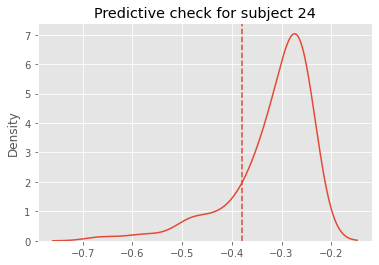

In [21]:
subject_no = npr.choice(holdout_subjects) 
sns.kdeplot(rep_ll_per_zi_ppca[:,subject_no]).set_title("Predictive check for subject "+str(subject_no))
plt.axvline(x=obs_ll_per_zi_ppca[subject_no], linestyle='--')



In [22]:
#beingsaved = plt.figure()
#sns.kdeplot(rep_ll_per_zi_ppca[:,subject_no]).set_title("PPCA: Predictive check for subject "+str(subject_no))
#plt.axvline(x=obs_ll_per_zi_ppca[subject_no], linestyle='--')
#beingsaved.savefig('ppc_random_subject_plot.eps', format='eps', dpi=1200)


## Fit latent variable model: PICA (with Laplacian prior)

The model is defined and fitted using variational inference and the functions for this is found in the file "ultils_deconfounder.py".

In [23]:
model_pica, surrogate_posterior_pica, w_mean_pica, w_stddv_pica, z_mean_pica, z_stddv_pica, losses_pica = fit_pica(x_train = x_train,
                                                                                                                   latent_dim = 3,
                                                                                                                   mask = 1-holdout_mask,
                                                                                                                   stddv_datapoints = 0.5)

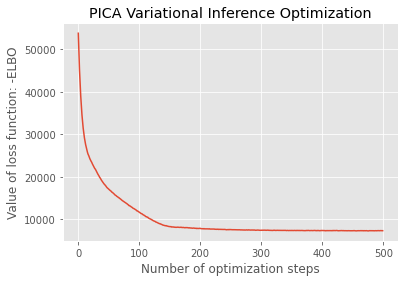

In [24]:
plt.plot(losses_pica)
plt.xlabel("Number of optimization steps")
plt.ylabel("Value of loss function: -ELBO")
plt.title("PICA Variational Inference Optimization")
plt.show()

#beingsaved = plt.figure()
#plt.plot(losses_pica)
#plt.xlabel("Number of optimization steps")
#plt.ylabel("Value of loss function: -ELBO")
#plt.title("PICA Variational Inference Optimization")
#beingsaved.savefig('pica_vi_loss_plot.eps', format='eps', dpi=1200)


## Posterior Predictive Checks: PICA

The fitness of the model is checked and the functions for this is found in the file "ultils_deconfounder.py".

n_rep is the number of replicated datasets we generate and n_eval is the number of samples drawn from Z and W. 

In [25]:
overall_pval_pica, holdout_subjects, rep_ll_per_zi_pica, obs_ll_per_zi_pica = ppc_pica(x_train = x_train, 
                                                                                       x_vad = x_vad,
                                                                                       mask = holdout_mask,
                                                                                       holdout_row = holdout_row,
                                                                                       model = model_pica, 
                                                                                       surrogate_posterior = surrogate_posterior_pica,
                                                                                       w_mean = w_mean_pica,
                                                                                       w_stddv = w_stddv_pica,
                                                                                       z_mean = z_mean_pica,
                                                                                       z_stddv = z_stddv_pica,
                                                                                       stddv_datapoints = 0.5)

print("Predictive check p-value (PICA)", overall_pval_pica)

Predictive check p-value (PICA) 0.359247311827957


Predictive check graph for random subject:

In [26]:
#subject_no = npr.choice(holdout_subjects) 
#sns.kdeplot(rep_ll_per_zi_pica[:,subject_no]).set_title("Predictive check for subject "+str(subject_no))
#plt.axvline(x=obs_ll_per_zi_pica[subject_no], linestyle='--')

## Fit Latent Variable Model: Bayesian GMM

First: Make a class that inherits the attribbutes from tfd.TransformedDistribubtion such that we can e.g. use the method sample from this distribution. 

The `joint_log_prob` function:

Args:
    observations: `[n, d]`-shaped `Tensor` representing Bayesian Gaussian
      Mixture model draws. Each sample is a length-`d` vector.
    mix_probs: `[K]`-shaped `Tensor` representing random draw from
      `Dirichlet` prior.
    loc: `[K, d]`-shaped `Tensor` representing the location parameter of the
      `K` components.
    chol_precision: `[K, d, d]`-shaped `Tensor` representing `K` lower
      triangular `cholesky(Precision)` matrices, each being sampled from
      a Wishart distribution.

  Returns:
    log_prob: `Tensor` representing joint log-density over all inputs.

Precision is the inverse covariance, therefore we take the inverse of the precision in order to get the covaraince matrix. I.e. instead of dividing with the covariance, we multiply with the precision. 

arg.max is to find the indices of the maximum values such that we have an estimate of which of the K normal distributions the observation belongs/ is assigned to. Why we take the max, we shall explain in a second.

Ultimately z_post is and $N \times 1$ matrix.

Not sure why we take the log of the mixture probabilities and substract the remaining...
BECAUSE we have

$$\log(\theta_{\text{mean}}) - \sum_{M}\frac{(x_{\text{train}}-\mu_{\text{mean}})^2}{\sigma^2_{\text{mean}}},$$

here the first part is the estimated mixture probabilities, which are minus something when log is taken. The second part is the one we wish to be as small as possible and when substarcting the second part, we wish to find the maximum value - i.e. the one with the smallest second term. The indices (of K possible) hereof are the estimates of the latent variables. 

Explore the bandedness of T by using a cholesky decomposition, where L in LL^T is lower triangular. Therefore, remember that in the Gaussian distribution, we do not use the cholesky lower triangular as scale but the precision inversed en square root...

In [27]:
%%capture 
z_post, mu_post, pi_post, precision_post, sigma_post, acceptance_rate = fit_gmm(x_train = x_train, components = 3);

In [28]:
acceptance_rate

0.546

Graph of three HMC chains samples of the (one out of five) mixture probability, the figure is presented in the project:

In [29]:
#z_post, mu_post, pi_post, precision_post, sigma_post, acceptance_rate, is_accepted, mix_probs1, mix_probs2, mix_probs3 = fit_gmm2(x_train = x_train, components = 5)

In [30]:
#plt.plot(mix_probs1[:,1], color="blue")
#plt.plot(mix_probs2[:,0], color="lightgreen")
#plt.plot(mix_probs3[:,4], color="orange")
#plt.xlabel("Steps")
#plt.ylabel("Mixture probability")
#plt.title("Three HMC chain samples of one of the mixture probabilities")
#plt.show
#
##beingsaved = plt.figure()
##plt.plot(mix_probs1[:,1], color="blue")
##plt.plot(mix_probs2[:,0], color="lightgreen")
##plt.plot(mix_probs3[:,4], color="orange")
##plt.xlabel("Steps")
##plt.ylabel("Mixture probability")
##plt.title("Three HMC chain samples of one mixture probability")
##
##beingsaved.savefig('hmc_chain_plot.eps', format='eps', dpi=1200)



## Posterior Predictive Checks: GMM

In [31]:
overall_pval_gmm = ppc_gmm(x_train = x_train, 
                           x_vad = x_vad,
                           components = 3, 
                           holdout_mask = holdout_mask,
                           z_post = z_post,
                           mu_post = mu_post,
                           pi_post = pi_post,
                           sigma_post = sigma_post,
                           n_rep = 100, 
                           n_eval = 100)

In [32]:
print("Predictive check p-value (GMM)", overall_pval_gmm)

Predictive check p-value (GMM) 0.46307692307692305


## Fit Latent Variable Model: DLGM (with sigmoid activation function)


Define model:

In [33]:
model_dlgm, surrogate_posterior_dlgm, w0_mean_dlgm, w0_stddv_dlgm, z0_mean_dlgm, z0_stddv_dlgm, losses_dlgm = fit_dlgm(x_train = x_train,
                                                                                                                      prior_stddv_datapoints = 1,
                                                                                                                      K = [5, 3, 2])    

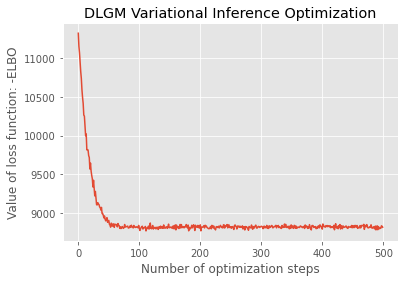

In [34]:
plt.plot(losses_dlgm)
plt.xlabel("Number of optimization steps")
plt.ylabel("Value of loss function: -ELBO")
plt.title("DLGM Variational Inference Optimization")
plt.show()

#beingsaved = plt.figure()
#plt.plot(losses_dlgm)
#plt.xlabel("Number of optimization steps")
#plt.ylabel("Value of loss function: -ELBO")
#plt.title("DLGM Variational Inference Optimization")
#beingsaved.savefig('dlgm_vi_loss_plot.eps', format='eps', dpi=1200)




# Posterior Predictive Checks: DLGM

In [35]:
overall_pval_dlgm, holdout_subjects_dlgm, rep_ll_per_zi_dlgm, obs_ll_per_zi_dlgm = ppc_dlgm(x_train = x_train,
                                                                                            x_vad = x_vad,
                                                                                            mask = holdout_mask,
                                                                                            holdout_row = holdout_row,
                                                                                            model = model_dlgm, 
                                                                                            surrogate_posterior = surrogate_posterior_dlgm,
                                                                                            w0_mean = w0_mean_dlgm,
                                                                                            w0_stddv = w0_stddv_dlgm,
                                                                                            z0_mean = z0_mean_dlgm,
                                                                                            z0_stddv = z0_stddv_dlgm,
                                                                                           stddv_datapoints = 1)

print("Predictive check p-value (DLGM)", overall_pval_dlgm)

Predictive check p-value (DLGM) 0.4580430107526882


## Fit Latent Variable Model: PMF (omitted because it did not pass the model check)

In [36]:
#model_pmf, surrogate_posterior_pmf, w_conc_pmf, w_rate_pmf, z_conc_pmf, z_rate_pmf, losses_pmf = fit_pmf(x_train = x_train, latent_dim = 3, mask = 1-holdout_mask, gamma_prior = 0.1)

In [37]:
#overall_pval_pmf, holdout_subjects_pmf, rep_ll_per_zi_pmf, obs_ll_per_zi_pmf = ppc_dlgm(x_train = x_train,
#                                                                                            x_vad = x_vad,
#                                                                                            mask = holdout_mask,
#                                                                                            holdout_row = holdout_row,
#                                                                                            model = model_pmf, 
#                                                                                            surrogate_posterior = surrogate_posterior_pmf,
#                                                                                            w_mean = w_conc_pmf,
#                                                                                            w_stddv = w_rate_pmf,
#                                                                                            z_mean = z_conc_pmf,
#                                                                                            z_stddv = z_rate_pmf)
#
#print("Predictive check p-value (PMF)", overall_pval_pmf)

## Causal inference with estimated latent variables as substitue confounders

We fit a linear regression model as the outcome model as a simple model and consequence of real outcome variables. I.e. the target is $Y_i$ for $i = 1,...,N$ and the regressors are the multiple causes used in the LVMs, $X_i$ for $i = 1,...,N$. Lastly, we correct for the estimated substitue confounder, $Z_i$ for $i = 1,...,N$, by including it into the regressors. Note that we could take a finite set of the causes in order to ensure positivity in causal inference and therefore, we could omit one of the causes used in the LVMs. However, we shall not do so since the number of causes are already finite. 

## PPCA

We approximate with the inferred mean the random variables, $Z$, that are substitue confounders and augment the regressors into a gathered dataset.

In [38]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score


def fit_causal_model_OLS(X, dfy, dfX_causal_inf, z_mean, data_dim_causal_inf):
    
    z_hat_ppca = z_mean
    X_aug_ppca = np.column_stack([X, z_hat_ppca])
    
    X_train_ppca, X_test_ppca, y_train_ppca, y_test_ppca = train_test_split(X_aug_ppca, 
                                                                            dfy, 
                                                                            test_size=0.2, 
                                                                            random_state=0)
    
    dcf_ppca_X_train = sm.add_constant(X_train_ppca)
    dcf_ppca_ols_model = sm.OLS(y_train_ppca, dcf_ppca_X_train)
    dcf_ppca_result = dcf_ppca_ols_model.fit(maxiter=5000)
    
    
    res = pd.DataFrame({"causal_mean": dcf_ppca_result.params[:data_dim_causal_inf+1], \
                  "causal_std": dcf_ppca_result.bse[:data_dim_causal_inf+1], \
                  "causal_025": dcf_ppca_result.conf_int()[:data_dim_causal_inf+1,0], \
                  "causal_975": dcf_ppca_result.conf_int()[:data_dim_causal_inf+1,1], \
                   "causal_pval": dcf_ppca_result.pvalues[:data_dim_causal_inf+1]})
    res["causal_sig"] = (res["causal_pval"] < 0.05)
    res = res.T
    res.columns = np.concatenate([["intercept"], np.array(dfX_causal_inf.columns)])
    res = res.T
    
    regr_ppca = linear_model.LinearRegression()
    lm_ppca = regr_ppca.fit(X_train_ppca, y_train_ppca)
    y_pred_ppca = lm_ppca.predict(X_test_ppca)
    
    mse_ppca = mean_squared_error(y_test_ppca, y_pred_ppca) # MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))
    r2_score_ppca = r2_score(y_test_ppca, y_pred_ppca)

    nodcfX_train = sm.add_constant(X_train_ppca[:,:X.shape[1]])
    nodcfols_model = sm.OLS(y_train_ppca, nodcfX_train)
    nodcfresult = nodcfols_model.fit(maxiter=5000)

    res["noncausal_mean"] = np.array(nodcfresult.params)
    res["noncausal_std"] = np.array(nodcfresult.bse)
    res["noncausal_025"] = np.array(nodcfresult.conf_int()[:,0])
    res["noncausal_975"] = np.array(nodcfresult.conf_int()[:,1])
    res["noncausal_pval"] = np.array(nodcfresult.pvalues)
    res["noncausal_sig"] = (res["noncausal_pval"] < 0.05)

    res["diff"] = res["causal_mean"] - res["noncausal_mean"]
    res["pval_diff"] = res["causal_pval"] - res["noncausal_pval"]
    
    regr_nodcf = linear_model.LinearRegression()
    lm_nodcf = regr_nodcf.fit(X_train_ppca[:,:X.shape[1]], y_train_ppca)
    y_pred_nodcf = lm_nodcf.predict(X_test_ppca[:,:X.shape[1]])
    
    mse_nodcf = mean_squared_error(y_test_ppca, y_pred_nodcf) # MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))
    r2_score_nodcf = r2_score(y_test_ppca, y_pred_nodcf)
    
    return dcf_ppca_result, nodcfresult, res, y_pred_ppca, y_pred_nodcf, mse_ppca, mse_nodcf, r2_score_ppca, r2_score_nodcf, y_test_ppca

In [39]:
dcf_ppca_result, nodcfresult, res_ppca, y_pred_ppca, y_pred, mse_ppca, mse_nodcf, r2_score_ppca, r2_score_nodcf, y_test_ppca = fit_causal_model_OLS(X = X, 
                                                                                                                                  dfy = dfy,
                                                                                                                                  dfX_causal_inf = dfX,
                                                                                                                                  z_mean = z_mean_ppca,
                                                                                                                                  data_dim_causal_inf = data_dim) 

In [40]:
print(dcf_ppca_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     83.78
Date:                Sun, 05 Sep 2021   Prob (F-statistic):          7.66e-115
Time:                        16:07:13   Log-Likelihood:                -1168.8
No. Observations:                 404   AIC:                             2372.
Df Residuals:                     387   BIC:                             2440.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.4593      0.224    100.098      0.0

In [41]:
print(nodcfresult.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     102.2
Date:                Sun, 05 Sep 2021   Prob (F-statistic):          9.64e-117
Time:                        16:07:13   Log-Likelihood:                -1171.5
No. Observations:                 404   AIC:                             2371.
Df Residuals:                     390   BIC:                             2427.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.4804      0.224    100.452      0.0

In [42]:
res_ppca.sort_values("pval_diff", ascending=True)[["pval_diff", "causal_pval", "noncausal_pval", "causal_sig", "noncausal_sig", "causal_mean", "noncausal_mean"]]

,pval_diff,causal_pval,noncausal_pval,causal_sig,noncausal_sig,causal_mean,noncausal_mean
AGE,-0.347878,0.479807,8.276851e-01,False,False,-0.345467,-0.087855
INDUS,-0.151798,0.779307,9.311050e-01,False,False,-0.135807,0.037631
intercept,0.0,0.0,7.880479e-281,True,True,22.459346,22.480353
LSTAT,0.0,0.0,5.257076e-18,True,True,-4.028856,-3.519063
PTRATIO,0.0,0.0,1.747353e-13,True,True,-2.739162,-2.264362
RM,0.0,0.0,6.837385e-15,True,True,3.446869,2.605803
DIS,0.000001,0.000001,2.771759e-10,True,True,-2.740743,-2.919351
TAX,0.000144,0.005205,5.061523e-03,True,True,-2.022986,-1.852162
NOX,0.000691,0.000841,1.503121e-04,True,True,-1.948916,-1.868366
ZN,0.000991,0.003052,2.060526e-03,True,True,1.316598,1.044378


In [43]:
print("MSE for deconfounding with PPCA:", mse_ppca)
print("MSE for classical linear regression without deconfounding:", mse_nodcf)
print("R^2 for deconfounding with PPCA:", r2_score_ppca)
print("R^2 for classical linear regression without deconfounding:", r2_score_nodcf)

MSE for deconfounding with PPCA: 32.71851797486853
MSE for classical linear regression without deconfounding: 33.44897999767657
R^2 for deconfounding with PPCA: 0.598192985745472
R^2 for classical linear regression without deconfounding: 0.5892223849182503


## PICA

We approximate with the inferred mean the random variables, $Z$, that are substitue confounders and augment the regressors into a gathered dataset.

In [44]:
dcf_pica_result, nodcfresult, res_pica, y_pred_pica, y_pred, mse_pica, mse_nodcf, r2_score_pica, r2_score_nodcf, y_test_pica = fit_causal_model_OLS(X = X, 
                                                                                                                                  dfy = dfy,
                                                                                                                                  dfX_causal_inf = dfX,
                                                                                                                                  z_mean = z_mean_pica,
                                                                                                                                  data_dim_causal_inf = data_dim) 

In [45]:
print(dcf_pica_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     83.16
Date:                Sun, 05 Sep 2021   Prob (F-statistic):          2.30e-114
Time:                        16:07:14   Log-Likelihood:                -1170.0
No. Observations:                 404   AIC:                             2374.
Df Residuals:                     387   BIC:                             2442.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.4904      0.224    100.325      0.0

In [46]:
print(nodcfresult.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     102.2
Date:                Sun, 05 Sep 2021   Prob (F-statistic):          9.64e-117
Time:                        16:07:14   Log-Likelihood:                -1171.5
No. Observations:                 404   AIC:                             2371.
Df Residuals:                     390   BIC:                             2427.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.4804      0.224    100.452      0.0

In [47]:
res_pica.sort_values("pval_diff", ascending=True)[["pval_diff", "causal_pval", "noncausal_pval", "causal_sig", "noncausal_sig", "causal_mean", "noncausal_mean"]]

,pval_diff,causal_pval,noncausal_pval,causal_sig,noncausal_sig,causal_mean,noncausal_mean
AGE,-0.338554,0.489131,8.276851e-01,False,False,-0.322765,-0.087855
INDUS,-0.116211,0.814894,9.311050e-01,False,False,-0.11206,0.037631
intercept,0.0,0.0,7.880479e-281,True,True,22.490449,22.480353
LSTAT,0.0,0.0,5.257076e-18,True,True,-3.93692,-3.519063
PTRATIO,0.0,0.0,1.747353e-13,True,True,-2.55,-2.264362
RM,0.0,0.0,6.837385e-15,True,True,3.209269,2.605803
DIS,0.000001,0.000001,2.771759e-10,True,True,-2.677126,-2.919351
NOX,0.000316,0.000467,1.503121e-04,True,True,-1.995505,-1.868366
ZN,0.000475,0.002536,2.060526e-03,True,True,1.342368,1.044378
RAD,0.001764,0.002321,5.570378e-04,True,True,2.070344,2.126124


In [48]:
print("MSE for deconfounding with PICA:", mse_pica)
print("MSE for classical linear regression without deconfounding:", mse_nodcf)
print("R^2 for deconfounding with PICA:", r2_score_pica)
print("R^2 for classical linear regression without deconfounding:", r2_score_nodcf)

MSE for deconfounding with PICA: 32.91805580102904
MSE for classical linear regression without deconfounding: 33.44897999767657
R^2 for deconfounding with PICA: 0.5957425172303032
R^2 for classical linear regression without deconfounding: 0.5892223849182503


## DLGM

We approximate with the inferred mean the random variables, $Z$, that are substitue confounders and augment the regressors into a gathered dataset.

In [49]:
dcf_dlgm_result, nodcfresult, res_dlgm, y_pred_dlgm, y_pred, mse_dlgm, mse_nodcf, r2_score_dlgm, r2_score_nodcf, y_test_dlgm = fit_causal_model_OLS(X = X, 
                                                                                                                                  dfy = dfy,
                                                                                                                                  dfX_causal_inf = dfX,
                                                                                                                                  z_mean = z0_mean_dlgm,
                                                                                                                                  data_dim_causal_inf = data_dim) 

In [50]:
print(dcf_dlgm_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     74.41
Date:                Sun, 05 Sep 2021   Prob (F-statistic):          3.34e-113
Time:                        16:07:14   Log-Likelihood:                -1168.1
No. Observations:                 404   AIC:                             2374.
Df Residuals:                     385   BIC:                             2450.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.4612      0.224    100.071      0.0

In [51]:
print(nodcfresult.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     102.2
Date:                Sun, 05 Sep 2021   Prob (F-statistic):          9.64e-117
Time:                        16:07:14   Log-Likelihood:                -1171.5
No. Observations:                 404   AIC:                             2371.
Df Residuals:                     390   BIC:                             2427.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.4804      0.224    100.452      0.0

In [52]:
res_dlgm.sort_values("pval_diff", ascending=True)[["pval_diff", "causal_pval", "noncausal_pval", "causal_sig", "noncausal_sig", "causal_mean", "noncausal_mean"]]

,pval_diff,causal_pval,noncausal_pval,causal_sig,noncausal_sig,causal_mean,noncausal_mean
INDUS,-0.132817,0.798288,9.311050e-01,False,False,0.111544,0.037631
AGE,-0.014664,0.813021,8.276851e-01,False,False,-0.095601,-0.087855
B,-0.00122,0.005044,6.263236e-03,True,True,0.760558,0.740411
ZN,-0.000783,0.001278,2.060526e-03,True,True,1.097626,1.044378
TAX,-0.000083,0.004978,5.061523e-03,True,True,-1.863895,-1.852162
NOX,-0.000061,0.000089,1.503121e-04,True,True,-1.950885,-1.868366
DIS,-0.0,0.0,2.771759e-10,True,True,-2.970707,-2.919351
intercept,0.0,0.0,7.880479e-281,True,True,22.461159,22.480353
LSTAT,0.0,0.0,5.257076e-18,True,True,-3.492013,-3.519063
RM,0.0,0.0,6.837385e-15,True,True,2.61182,2.605803


In [53]:
print("MSE for deconfounding with DLGM:", mse_dlgm)
print("MSE for classical linear regression without deconfounding:", mse_nodcf)
print("R^2 for deconfounding with DLGM:", r2_score_dlgm)
print("R^2 for classical linear regression without deconfounding:", r2_score_nodcf)

MSE for deconfounding with DLGM: 33.210075599620204
MSE for classical linear regression without deconfounding: 33.44897999767657
R^2 for deconfounding with DLGM: 0.5921563033478392
R^2 for classical linear regression without deconfounding: 0.5892223849182503


## GMM

We approximate with the inferred random variables, $Z$, that are substitue confounders and augment the regressors into a gathered dataset.

In [54]:
dcf_gmm_result, nodcfresult, res_gmm, y_pred_gmm, y_pred, mse_gmm, mse_nodcf, r2_score_gmm, r2_score_nodcf, y_test_gmm = fit_causal_model_OLS(X = X, 
                                                                                                                                  dfy = dfy,
                                                                                                                                  dfX_causal_inf = dfX,
                                                                                                                                  z_mean = z_post,
                                                                                                                                  data_dim_causal_inf = data_dim) 

In [55]:
print(dcf_gmm_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     95.86
Date:                Sun, 05 Sep 2021   Prob (F-statistic):          1.44e-116
Time:                        16:07:14   Log-Likelihood:                -1169.4
No. Observations:                 404   AIC:                             2369.
Df Residuals:                     389   BIC:                             2429.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.5001      0.543     39.616      0.0

In [56]:
print(nodcfresult.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     102.2
Date:                Sun, 05 Sep 2021   Prob (F-statistic):          9.64e-117
Time:                        16:07:14   Log-Likelihood:                -1171.5
No. Observations:                 404   AIC:                             2371.
Df Residuals:                     390   BIC:                             2427.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.4804      0.224    100.452      0.0

In [57]:
res_gmm.sort_values("pval_diff", ascending=True)[["pval_diff", "causal_pval", "noncausal_pval", "causal_sig", "noncausal_sig", "causal_mean", "noncausal_mean"]]

,pval_diff,causal_pval,noncausal_pval,causal_sig,noncausal_sig,causal_mean,noncausal_mean
INDUS,-0.319186,0.611919,9.311050e-01,False,False,0.225231,0.037631
B,-0.003904,0.002359,6.263236e-03,True,True,0.834168,0.740411
CRIM,-0.000808,0.000415,1.222501e-03,True,True,-1.135935,-1.027398
NOX,-0.000107,0.000043,1.503121e-04,True,True,-2.04466,-1.868366
ZN,-0.000026,0.002035,2.060526e-03,True,True,1.041797,1.044378
DIS,-0.0,0.0,2.771759e-10,True,True,-2.924753,-2.919351
PTRATIO,-0.0,0.0,1.747353e-13,True,True,-2.265047,-2.264362
LSTAT,-0.0,0.0,5.257076e-18,True,True,-3.596122,-3.519063
intercept,0.0,0.0,7.880479e-281,True,True,21.500086,22.480353
RM,0.0,0.0,6.837385e-15,True,True,2.582045,2.605803


In [58]:
print("MSE for deconfounding with GMM:", mse_gmm)
print("MSE for classical linear regression without deconfounding:", mse_nodcf)
print("R^2 for deconfounding with GMM:", r2_score_gmm)
print("R^2 for classical linear regression without deconfounding:", r2_score_nodcf)

MSE for deconfounding with GMM: 32.98023341949431
MSE for classical linear regression without deconfounding: 33.44897999767657
R^2 for deconfounding with GMM: 0.5949789312008817
R^2 for classical linear regression without deconfounding: 0.5892223849182503


## RESULTS:

In [59]:
df_results = pd.DataFrame(columns=['MSE', 'R^2'], index=['No deconfounding', 'GMM', 'PPCA', 'PICA', 'DLGM'])

In [60]:
df_results.loc['No deconfounding'] = [mse_nodcf, r2_score_nodcf]
df_results.loc['GMM'] = [mse_gmm, r2_score_gmm]
df_results.loc['PPCA'] = [mse_ppca, r2_score_ppca]
df_results.loc['PICA'] = [mse_pica, r2_score_pica]
df_results.loc['DLGM'] = [mse_dlgm, r2_score_dlgm]

In [61]:
df_results

,MSE,R^2
No deconfounding,33.44898,0.589222
GMM,32.980233,0.594979
PPCA,32.718518,0.598193
PICA,32.918056,0.595743
DLGM,33.210076,0.592156
